# Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lib_file import lib_path
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Data Loading

In [2]:
base_dir='input'
class_labels=os.listdir(base_dir)
class_labels.sort()
print(class_labels)

['covid', 'normal']


In [3]:
chart_data=[]
for target in class_labels:
    path=os.path.join(base_dir,target)
    size=len(os.listdir(path))
    chart_data.append(size)
    print(f'The target {target} has ({size}) samples in the dataset')

The target covid has (1000) samples in the dataset
The target normal has (1000) samples in the dataset


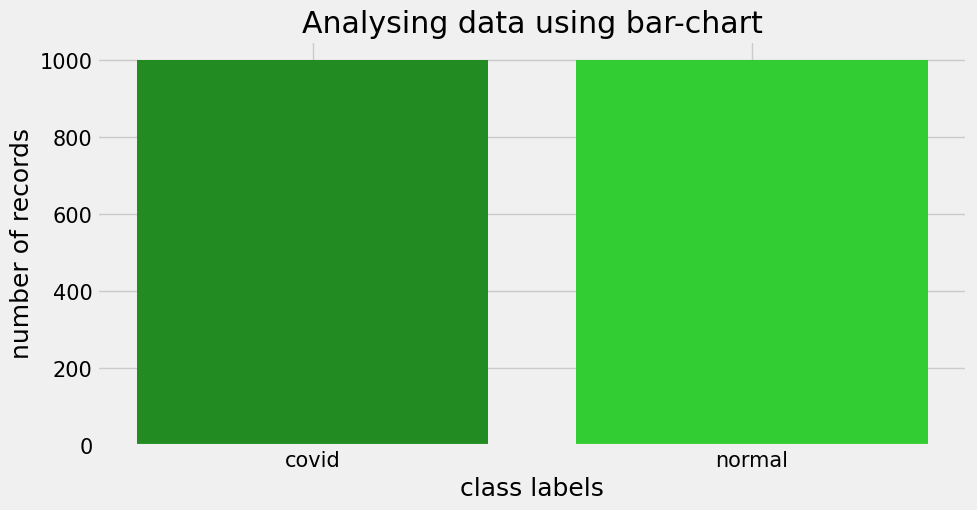

In [4]:
with plt.style.context(style="fivethirtyeight"):
    plt.figure(figsize=(10,5))
    plt.rcParams["font.size"]=15
    plt.bar(x=class_labels,
            height=chart_data,
            color=["forestgreen","limegreen","darkgreen"])
    plt.title(label="Analysing data using bar-chart")
    plt.xlabel(xlabel="class labels")
    plt.ylabel(ylabel="number of records")
    plt.show()

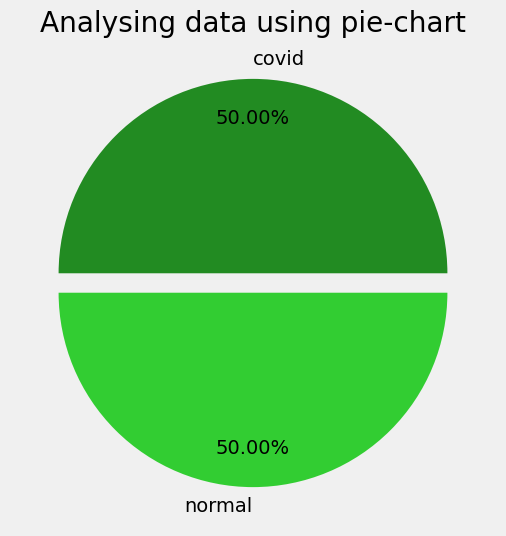

In [5]:
with plt.style.context(style="fivethirtyeight"):
    plt.figure(figsize=(6,6))
    plt.pie(x=chart_data,
        colors=["forestgreen","limegreen","darkgreen"],
        labels=class_labels,
        autopct='%.2f%%',
        pctdistance=0.80,
        explode=[0.05]*len(class_labels))
    plt.title(label="Analysing data using pie-chart")
    plt.show()

In [6]:
data=[]
labels=[]
count=0
for target in class_labels:
    path=os.path.join(base_dir,target)
    print(f'Images loading from {path}')
    image_names=os.listdir(path)
    for image_name in tqdm(image_names):
        image_path=os.path.join(path,image_name)
        image=cv2.imread(image_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image=cv2.resize(image,(128,128))
        image=np.array(image)
        image=image/255.0
        data.append(image)
        labels.append(count)
    count+=1

Images loading from input\covid


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 31.07it/s]


Images loading from input\normal


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.36it/s]


In [7]:
data=np.array(data)
labels=np.array(labels)

print(data.shape,labels.shape)

(2000, 128, 128, 3) (2000,)


In [8]:
from random import randint
def show_images(X,y,class_names):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        idx = randint(0, X.shape[0]-1)
        plt.imshow(X[idx])
        plt.axis("off")
        plt.title("Class:{}".format(class_names[y[idx]]))
    plt.tight_layout()
    plt.show()

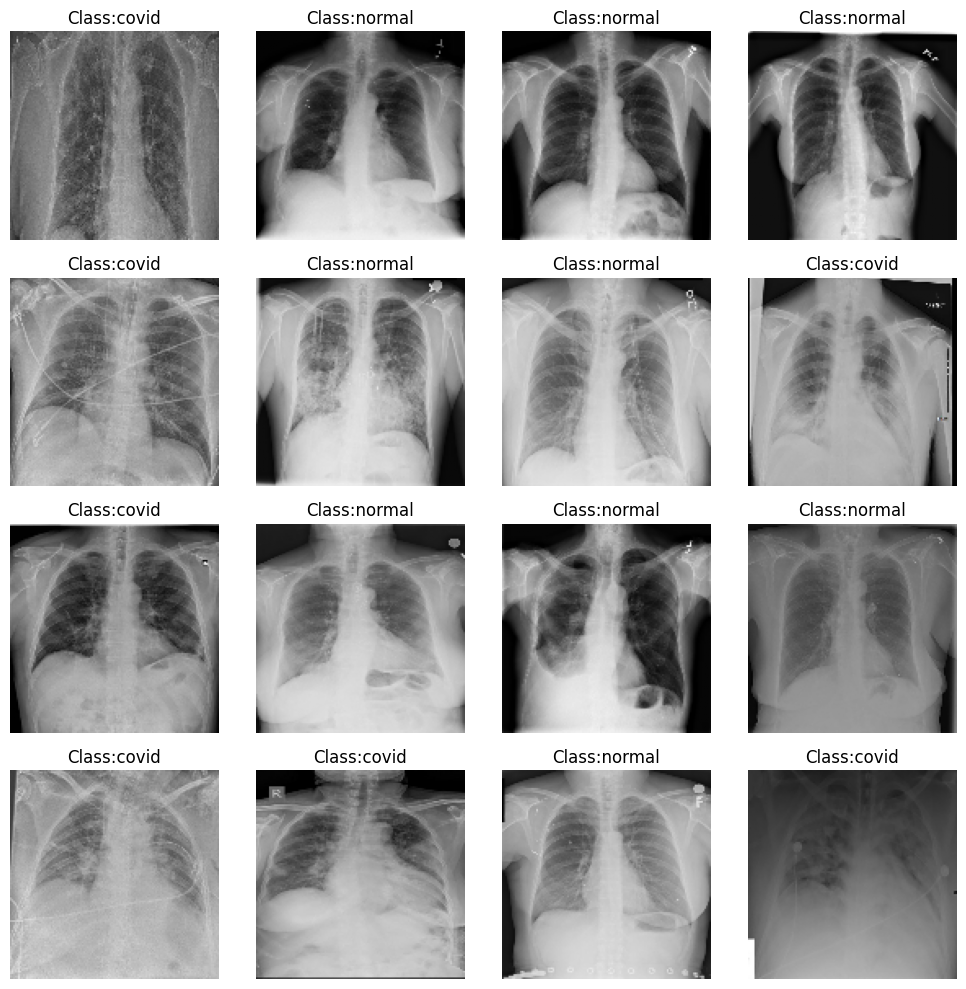

In [9]:
show_images(data,labels,class_labels)

In [10]:
y=to_categorical(labels)
X_train,X_test,y_train,y_test=train_test_split(data,y,test_size=0.2,random_state=101,shuffle=True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1600, 128, 128, 3) (400, 128, 128, 3) (1600, 2) (400, 2)


In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,BatchNormalization,Dense,Dropout,Flatten

In [12]:
cnn_model=Sequential()

cnn_model.add(Conv2D(filters=64,kernel_size=3,strides=(1,1),padding="same",activation="relu",input_shape = (128,128,3)))
cnn_model.add(Conv2D(filters=64,kernel_size=3,strides=(1,1),padding="same",activation="relu"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(2,2)))

cnn_model.add(Conv2D(filters=128,kernel_size=3,strides=(1,1),padding="same",activation="relu"))
cnn_model.add(Conv2D(filters=128,kernel_size=3,strides=(1,1),padding="same",activation="relu"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(2,2),padding="same"))

cnn_model.add(Conv2D(filters=256,kernel_size=3,strides=(1,1),padding="same",activation="relu"))
cnn_model.add(Conv2D(filters=256,kernel_size=3,strides=(1,1),padding="same",activation="relu"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(2,2),padding="same"))

cnn_model.add(Conv2D(filters=512,kernel_size=3,strides=(1,1),padding="same",activation="relu"))
cnn_model.add(Conv2D(filters=512,kernel_size=3,strides=(1,1),padding="same",activation="relu"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(2,2),padding="same"))

cnn_model.add(Flatten())
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(units=512,activation="relu"))
cnn_model.add(Dense(units=len(class_labels),activation="sigmoid"))

In [13]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       1

In [15]:
number_of_epochs=30
history=cnn_model.fit(x=X_train,y=y_train,batch_size=32,epochs=number_of_epochs,validation_data=(X_test,y_test),shuffle=True)

Epoch 1/30
50/50 [==============================] - 994s 20s/step - loss: 3.3025 - accuracy: 0.7837 - val_loss: 14.2250 - val_accuracy: 0.6800
Epoch 2/30
50/50 [==============================] - 884s 18s/step - loss: 0.3595 - accuracy: 0.8819 - val_loss: 3.3130 - val_accuracy: 0.4550
Epoch 3/30
50/50 [==============================] - 248s 5s/step - loss: 0.2248 - accuracy: 0.9087 - val_loss: 3.9380 - val_accuracy: 0.4325
Epoch 4/30
50/50 [==============================] - 275s 6s/step - loss: 0.2202 - accuracy: 0.9156 - val_loss: 4.8604 - val_accuracy: 0.4550
Epoch 5/30
50/50 [==============================] - 282s 6s/step - loss: 0.1775 - accuracy: 0.9306 - val_loss: 4.0544 - val_accuracy: 0.4500
Epoch 6/30
50/50 [==============================] - 283s 6s/step - loss: 0.1242 - accuracy: 0.9525 - val_loss: 3.1781 - val_accuracy: 0.4575
Epoch 7/30
50/50 [==============================] - 285s 6s/step - loss: 0.1277 - accuracy: 0.9525 - val_loss: 2.1231 - val_accuracy: 0.4525
Epoch 8/30

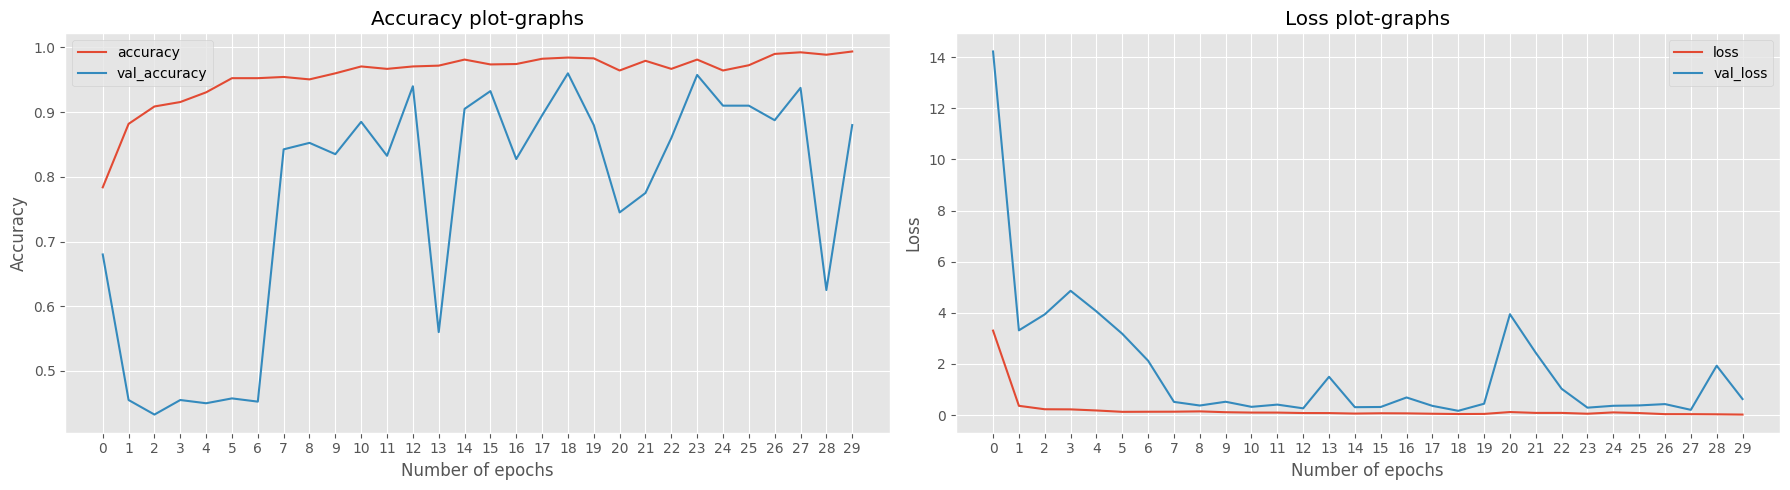

In [16]:
with plt.style.context(style='ggplot'):
    fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(18,5))
    axes[0].plot(history.history["accuracy"],label="accuracy")
    axes[0].plot(history.history["val_accuracy"],label="val_accuracy")
    axes[0].set_title(label='Accuracy plot-graphs')
    axes[0].set_xlabel(xlabel='Number of epochs')
    axes[0].set_ylabel(ylabel='Accuracy')
    axes[0].set_xticks(range(number_of_epochs))
    axes[0].legend()
    axes[1].plot(history.history["loss"],label="loss")
    axes[1].plot(history.history["val_loss"],label="val_loss")
    axes[1].set_title(label='Loss plot-graphs')
    axes[1].set_xlabel(xlabel='Number of epochs')
    axes[1].set_ylabel(ylabel='Loss')
    axes[1].set_xticks(range(number_of_epochs))
    axes[1].legend()
    fig.tight_layout()
    plt.show()

In [17]:
cnn_prediction=cnn_model.predict(X_test,batch_size=32,verbose=1)

13/13 [==============================] - 66s 5s/step


In [18]:
print(cnn_prediction)

[[1.08074064e-05 9.99990940e-01]
 [9.89077628e-01 7.11011887e-03]
 [3.15425007e-14 1.00000000e+00]
 [3.77210975e-03 9.95376706e-01]
 [9.99929309e-01 1.21644451e-04]
 [9.96292472e-01 7.27170706e-03]
 [9.99691725e-01 2.21282244e-04]
 [9.99972701e-01 1.95057000e-05]
 [5.10032692e-08 1.00000000e+00]
 [9.99946952e-01 3.77764190e-05]
 [4.67494661e-14 1.00000000e+00]
 [1.04202364e-07 1.00000000e+00]
 [9.99361038e-01 4.27603722e-04]
 [1.32303933e-12 1.00000000e+00]
 [2.91504421e-08 1.00000000e+00]
 [8.40695739e-01 8.44868720e-02]
 [3.76421213e-03 9.97224331e-01]
 [2.82999099e-06 9.99997497e-01]
 [8.33603144e-01 1.17313385e-01]
 [3.85166956e-08 1.00000000e+00]
 [1.88007525e-05 9.99992669e-01]
 [1.44550741e-01 8.39168429e-01]
 [1.27881910e-08 1.00000000e+00]
 [3.36377539e-08 1.00000000e+00]
 [2.29543716e-07 9.99999881e-01]
 [1.67516470e-02 9.84168649e-01]
 [9.99998569e-01 8.36017307e-07]
 [3.13612531e-06 9.99996662e-01]
 [1.00000000e+00 0.00000000e+00]
 [3.53297800e-01 6.48858368e-01]
 [9.999088

In [19]:
cnn_labels=[]
for i in range(len(cnn_prediction)):
    cnn_labels.append(np.argmax(cnn_prediction[i]))

In [20]:
print(cnn_labels)

[1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 

In [21]:
true_labels=[]
for i in range(len(y_test)):
    true_labels.append(np.argmax(y_test[i]))

In [22]:
print(true_labels)

[1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 

# Result Analysis

***Accuracy Score***

In [23]:
cnn_accuracy=accuracy_score(y_true=true_labels,y_pred=cnn_labels)
print(f'Validation accuracy of ComvolutionalNeuralNetwork model is {cnn_accuracy*100.0:.2f}%')

Validation accuracy of ComvolutionalNeuralNetwork model is 88.00%


***Classification Report***

In [24]:
print(classification_report(y_true=true_labels,y_pred=cnn_labels,target_names=class_labels))

              precision    recall  f1-score   support

       covid       0.90      0.82      0.86       182
      normal       0.86      0.93      0.89       218

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



***Confusion Matrix***

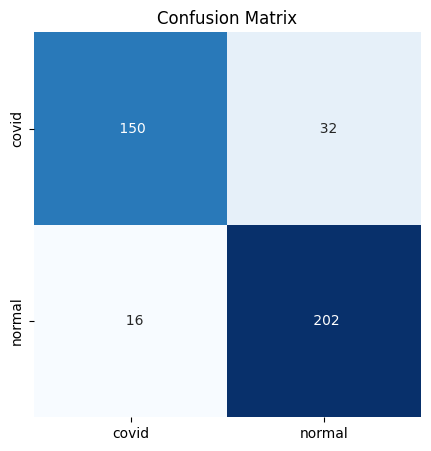

In [25]:
plt.figure(figsize=(5,5))
sns.heatmap(data=confusion_matrix(y_true=true_labels,y_pred=cnn_labels),
            annot=True,
            fmt='4d',
            cbar=False,
            cmap=plt.cm.Blues,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title(label='Confusion Matrix')
plt.show()

***Model Saving***

In [26]:
cnn_model.save(filepath="models/ConvolutionalNeuralNetwork_model.h5")